# Part D Data Cleaning

## D1 line graph

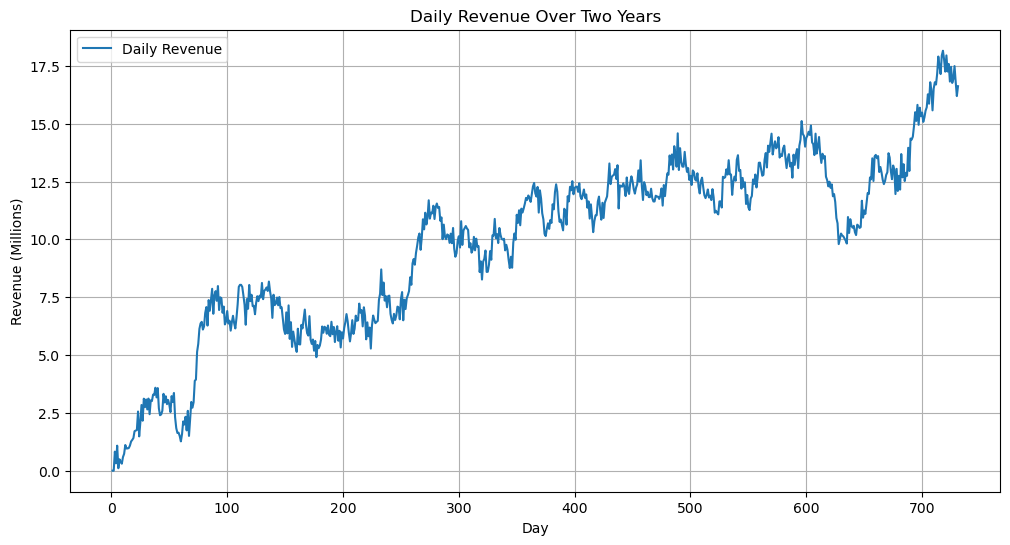

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("churn_clean.csv")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Day'], df['Revenue'], label='Daily Revenue')
plt.title('Daily Revenue Over Two Years')
plt.xlabel('Day')
plt.ylabel('Revenue (Millions)')
plt.grid(True)
plt.legend()
plt.savefig("daily_revenue_timeseries.png", dpi=300) 
plt.show()

## D2 Check for duplicate and missing days

In [11]:
expected_days = 731
actual_days = df['Day'].nunique()
print("Missing days:", expected_days - actual_days)

Missing days: 0


## D3 Augmented Dickey-Fuller Test

In [13]:
from statsmodels.tsa.stattools import adfuller

# Run the ADF test
adf_result = adfuller(df['Revenue'])

# Print the results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")

# Interpretation:
if adf_result[1] < 0.05:
    print("✅ The series is stationary (reject null hypothesis)")
else:
    print("❌ The series is NOT stationary (fail to reject null hypothesis)")

ADF Statistic: -1.9246121573101873
p-value: 0.32057281507939484
Critical Value 1%: -3.4393520240470554
Critical Value 5%: -2.8655128165959236
Critical Value 10%: -2.5688855736949163
❌ The series is NOT stationary (fail to reject null hypothesis)


## D4 Prepare for Data Analysis

## Step 1: Apply First-Order Differencing

In [15]:
# First-order differencing to remove trend
df['Revenue_diff'] = df['Revenue'].diff()

# Drop the first row with NaN from differencing
df_cleaned = df.dropna()

## Step 2: Split into Train and Test Sets

In [17]:
# Calculate index for 80% of the data
split_index = int(len(df_cleaned) * 0.8)

# Split the data
train = df_cleaned['Revenue_diff'].iloc[:split_index]
test = df_cleaned['Revenue_diff'].iloc[split_index:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 584, Test size: 146


## Step 3: Save the Cleaned Dataset

In [19]:
df_cleaned.to_csv("cleaned_revenue_timeseries.csv", index=False)

# Part E Analyze time series 

## Part E1 Visualizations

## Trend Plot

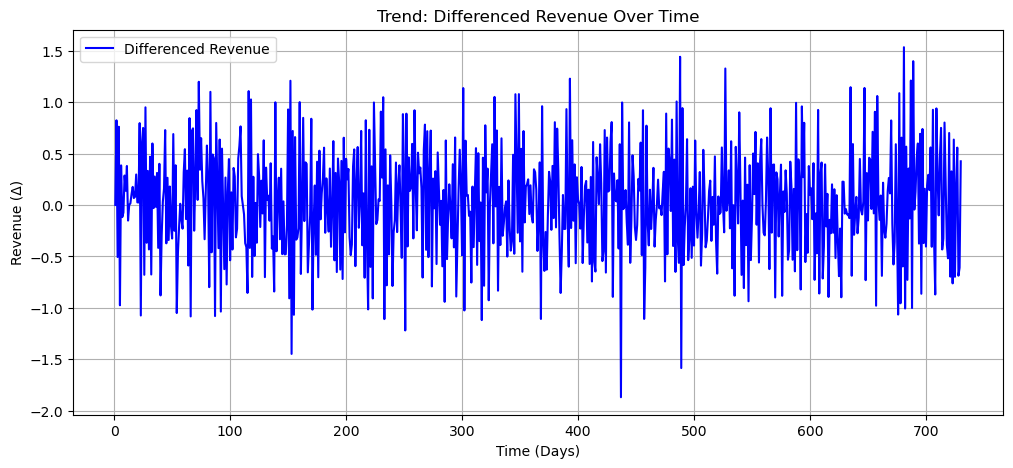

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(df['Revenue_diff'], label='Differenced Revenue', color='blue')
plt.title("Trend: Differenced Revenue Over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Revenue (Δ)")
plt.grid(True)
plt.legend()
plt.savefig("plot_trend_differenced.png", dpi=300)
plt.show()

## The Autocorrelation Function

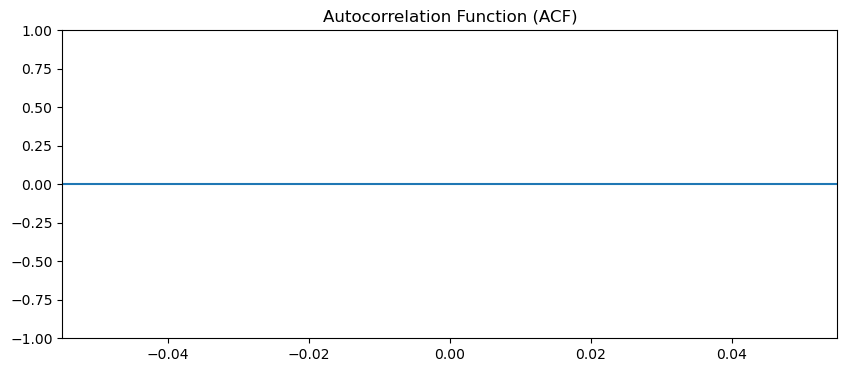

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

fig = plt.figure(figsize=(10, 4))
plot_acf(df['Revenue_diff'], lags=50, ax=fig.add_subplot(111))
plt.title("Autocorrelation Function (ACF)")
plt.savefig("plot_acf.png", dpi=300)
plt.show()


## Spectral Density Plot

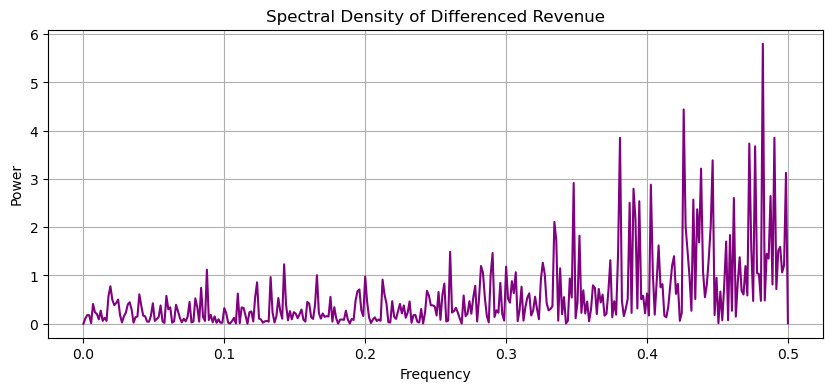

In [25]:
from scipy.signal import periodogram

freqs, power = periodogram(df['Revenue_diff'].dropna())
plt.figure(figsize=(10, 4))
plt.plot(freqs, power, color='purple')
plt.title("Spectral Density of Differenced Revenue")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.savefig("plot_spectral_density.png", dpi=300)
plt.show()

## Seasonal Decomposition

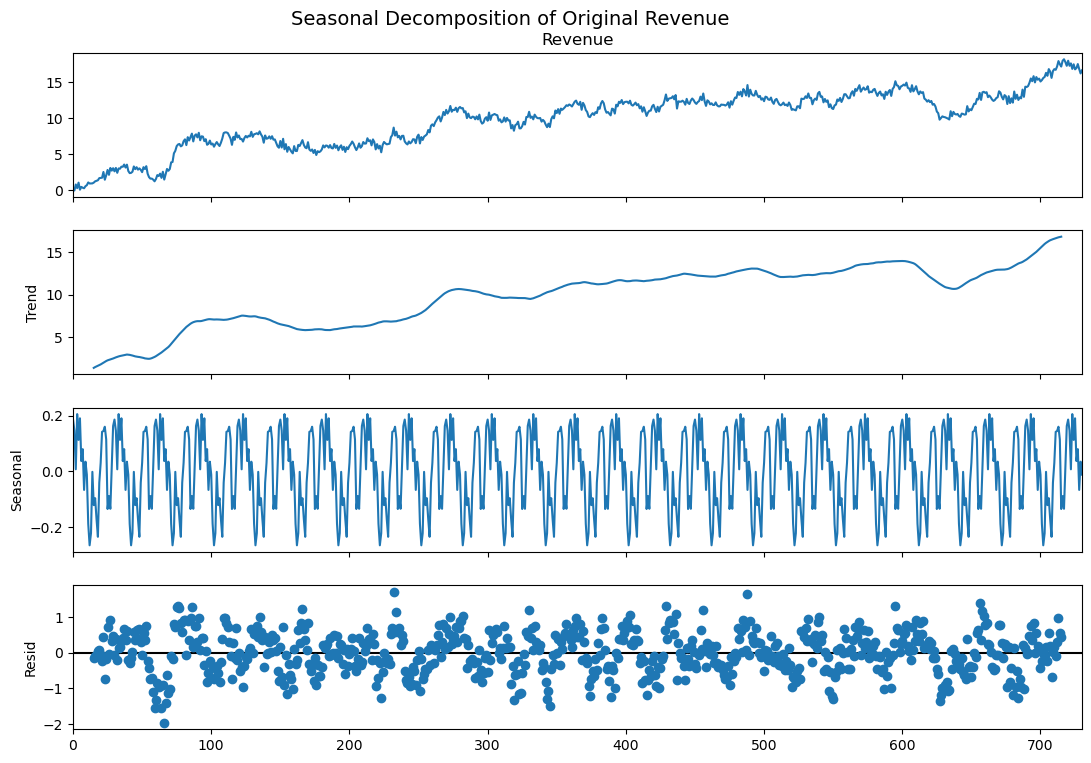

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

original_df = pd.read_csv("churn_clean.csv")
decomp = seasonal_decompose(original_df['Revenue'], model='additive', period=30)

fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition of Original Revenue", fontsize=14)
plt.savefig("plot_seasonal_decompose.png", dpi=300)
plt.show()

## Residual Plot

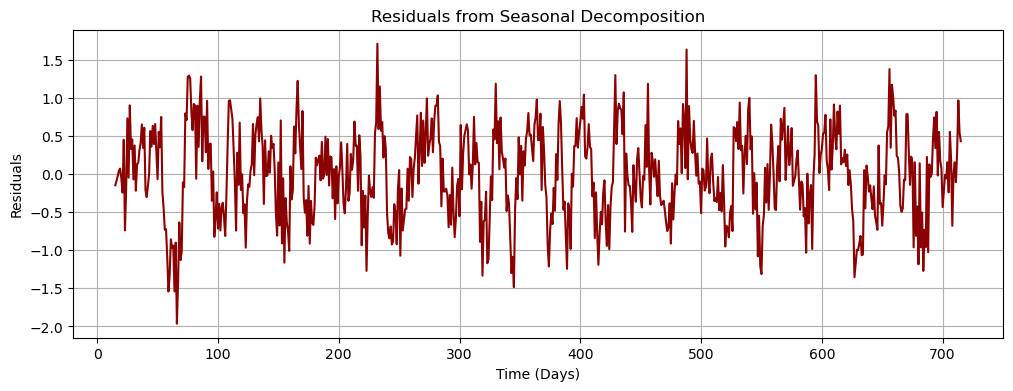

In [31]:
residual = decomp.resid.dropna()
plt.figure(figsize=(12, 4))
plt.plot(residual, color='darkred')
plt.title("Residuals from Seasonal Decomposition")
plt.xlabel("Time (Days)")
plt.ylabel("Residuals")
plt.grid(True)
plt.savefig("plot_residuals.png", dpi=300)
plt.show()

## E2: Auto ARIMA

In [87]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.7 MB/s eta 0:00:00


In [33]:
from pmdarima import auto_arima

series = df['Revenue_diff'].dropna()

# Use auto_arima to determine best model
model = auto_arima(series,
                   seasonal=False,
                   trace=True,
                   suppress_warnings=True,
                   stepwise=True,
                   error_action='ignore')

# Print summary of the selected model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=988.093, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1162.139, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=984.710, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1021.594, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=986.641, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=986.652, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=986.856, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=983.122, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1162.819, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=985.104, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=985.106, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1019.369, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=986.045, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.336 seconds
                               

## E3: Forecast

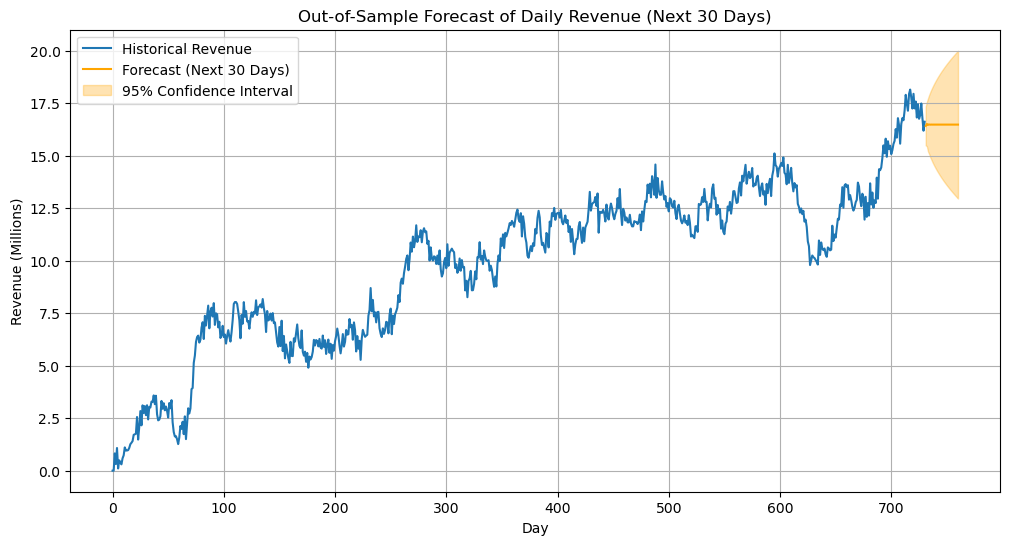

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Load full original data (not differenced)
df = pd.read_csv("churn_clean.csv")
revenue = df['Revenue']

# Fit ARIMA model to full revenue series
model = ARIMA(revenue, order=(1,1,0))  
model_fit = model.fit()

# Forecast the next 30 days
forecast_result = model_fit.get_forecast(steps=30)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create index for forecasted days
forecast_index = range(len(revenue), len(revenue) + 30)

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(revenue, label='Historical Revenue')
plt.plot(forecast_index, forecast, label='Forecast (Next 30 Days)', color='orange')
plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='orange', alpha=0.3, label='95% Confidence Interval')
plt.title('Out-of-Sample Forecast of Daily Revenue (Next 30 Days)')
plt.xlabel('Day')
plt.ylabel('Revenue (Millions)')
plt.legend()
plt.grid(True)
plt.savefig("final_forecast_revenue.png", dpi=300)
plt.show()

## E4: Output and Calculations

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load differenced dataset
df = pd.read_csv("cleaned_revenue_timeseries.csv")
series = df['Revenue_diff'].dropna()

# Train/test split
split_index = int(len(series) * 0.8)
train, test = series[:split_index], series[split_index:]

# Fit ARIMA(1,0,0) to the training set
model = ARIMA(train, order=(1, 0, 0))
model_fit = model.fit()

# Forecast for the length of the test set (not 30!)
forecast = model_fit.forecast(steps=len(test))

# Now they're both the same length: test vs forecast
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.3246275629527183
Root Mean Squared Error (RMSE): 0.5697609700152497
Mean Absolute Error (MAE): 0.4670346782998404


## F2: Final model compared to the test set

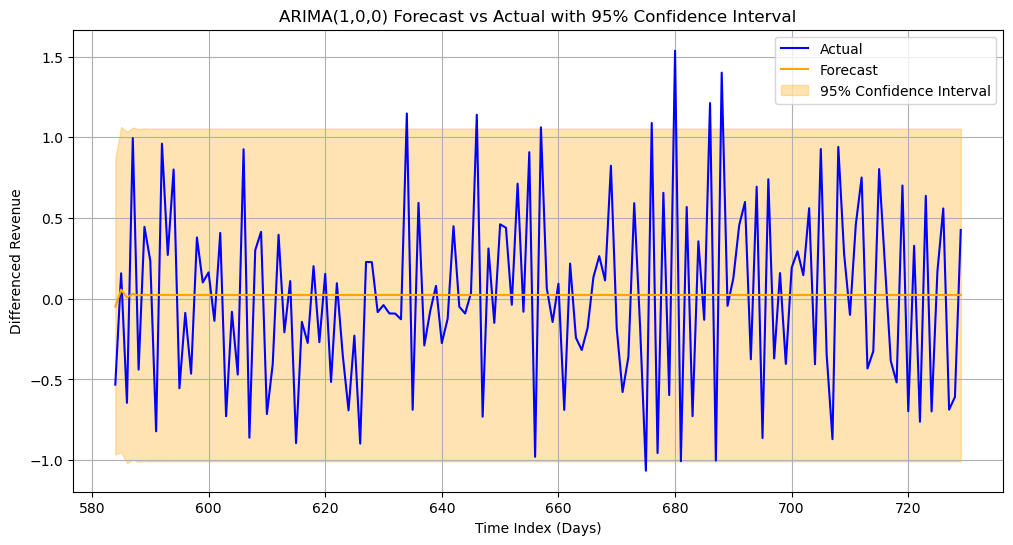

In [47]:
# Fit ARIMA(1,0,0)
model = ARIMA(train, order=(1, 0, 0))
model_fit = model.fit()

# Forecast with confidence intervals
forecast_result = model_fit.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence

# Plot forecast with cone
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.fill_between(test.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='orange', alpha=0.3, label='95% Confidence Interval')
plt.title("ARIMA(1,0,0) Forecast vs Actual with 95% Confidence Interval")
plt.xlabel("Time Index (Days)")
plt.ylabel("Differenced Revenue")
plt.legend()
plt.grid(True)
plt.savefig("forecast_with_confidence_cone.png", dpi=300)
plt.show()